In [1]:
HTML_MODE = True
if not HTML_MODE:
    %matplotlib widget
else:
    %matplotlib inline

### 週販レポート2025年版
# 標準ライブラリ
import os
from datetime import datetime, timedelta

# サードパーティライブラリ
import pandas as pd
from pandas import Timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from IPython.display import Markdown, display

# プロジェクト内モジュール
from gamedata import hard_sales as hs
from gamedata import plot_hard as ph
from gamedata import hard_info as hi
from gamedata import hard_event as he
from gamedata import chart_hard as ch

# レポート日付
from report_config import get_config

config = get_config()
report_date = config["date"]
report_event_mask = {'hard': 1.5, 'price':3, 'sale':2, 'soft':1.0}

def show_title(d:datetime) -> None:
    last_updated_str = d.strftime("%Y-%m-%d")
    mode = "[[LAB MODE]]" if not HTML_MODE else ""
    display(Markdown(f"# 国内ゲームハード週販レポート ({last_updated_str}) {mode}"))

show_title(report_date)

if not HTML_MODE:
    plt.show()

# 国内ゲームハード週販レポート (2025-09-21) 

* ハードウェアの販売データはファミ通の調査結果を元にしています。
* 一部のデータについては処理の都合上、1週間毎の値にアレンジしています。
* [過去の週販レポート](index.html)

## 直近4週間のハード売り上げ／累計推移


Nintendo Switchが3600万台に到達しました。歴代最多記録を更新し続けています。

それ以外に、目立った変化はありません。
Switch2は4万台をキープしていますが、まだまだ出荷が制限されている状況が続いています。
次回集計もこの水準になるでしょう。
PS5はオータムセール終了の揺り返しで、セール前と同じ8千台に戻りました。

In [2]:
def chart_4weeks() -> None:
    df1 = hs.load_hard_sales()
    # 4 weeks before
    before_4weeks = hs.current_report_date(df1) - Timedelta(weeks=4-1)
    (out1, style1) = ch.chart_units_by_date_hw(df1, begin=before_4weeks)
    display(style1)
    
chart_4weeks()

## 2025年の週販推移

現在はどの機種も5万以下の推移が続いています。年末モードに入る10月から10万近辺の値が出てくるのに期待です。

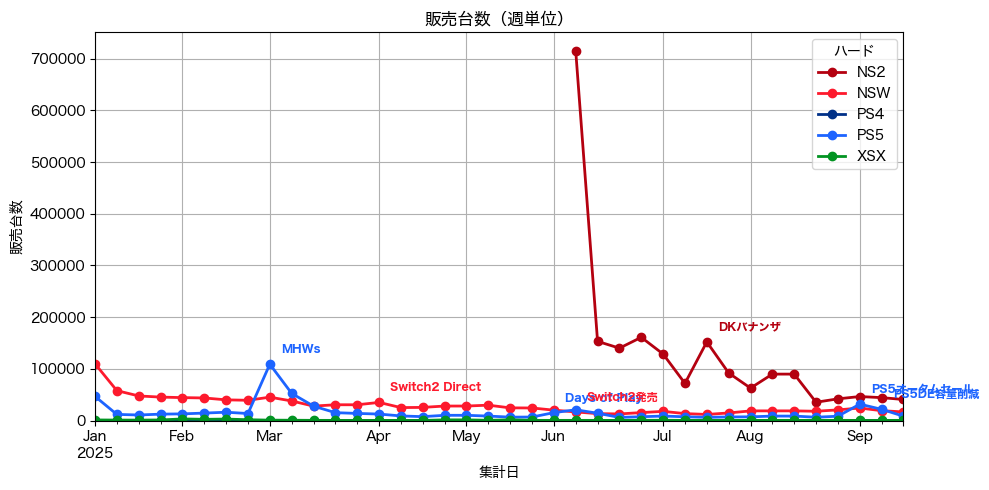

In [4]:
(fig, df) = ph.plot_sales(begin=datetime(2025,1,1), event_mask = report_event_mask)

### 2025年の週販推移(拡大）

PS5 オータムセール終了の影響がわかり易く現れています。


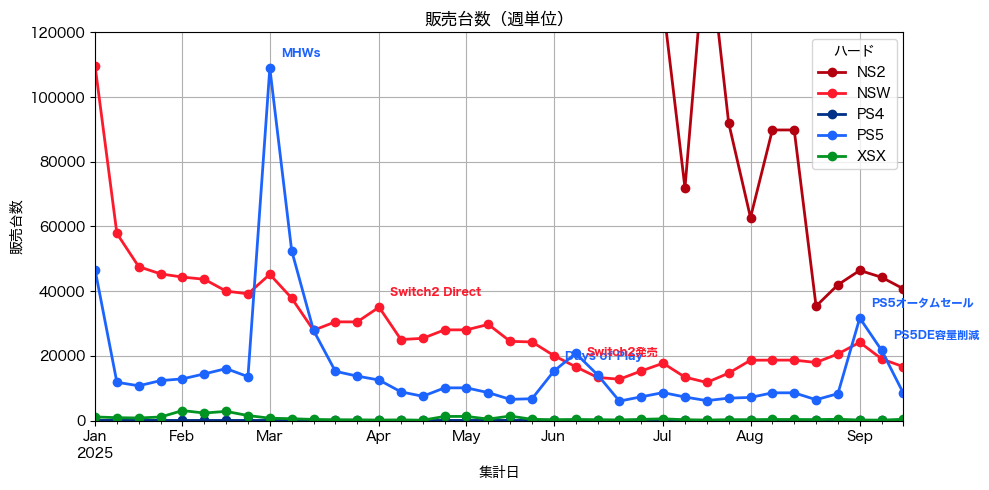

In [5]:
(fig, df) = ph.plot_sales(begin=datetime(2025,1,1), ymax=120000, event_mask=report_event_mask)

## Switch　3600万台到達

### 任天堂、歴代携帯ゲーム機の推移と今後

Switchの累計推移グラフがまだフラットにならずに傾いているというのが訳わからないですね。
DSも3DSも400週を超える頃には販売台数が減少し、累計グラフが水平になるんですけど。

#### 3700万台は難しい かも

ただ、この先、年末商戦でSwitch2の大量出荷があった場合には、
標準Switch, Switch OLEDはSwitch2に置き換わり、換えの効かないSwitch Liteが
Switchの主役になると予想します。そうなると5千/週になるので、ここから100万台積み上げて
3700万台になるのは難しいと思います。
もし、3700万台に行くとすれば、Switch2が年末に十分な数を出せずに、
2025年のホリデーにSwitchが結構なボリュームで売れた場合ですね。

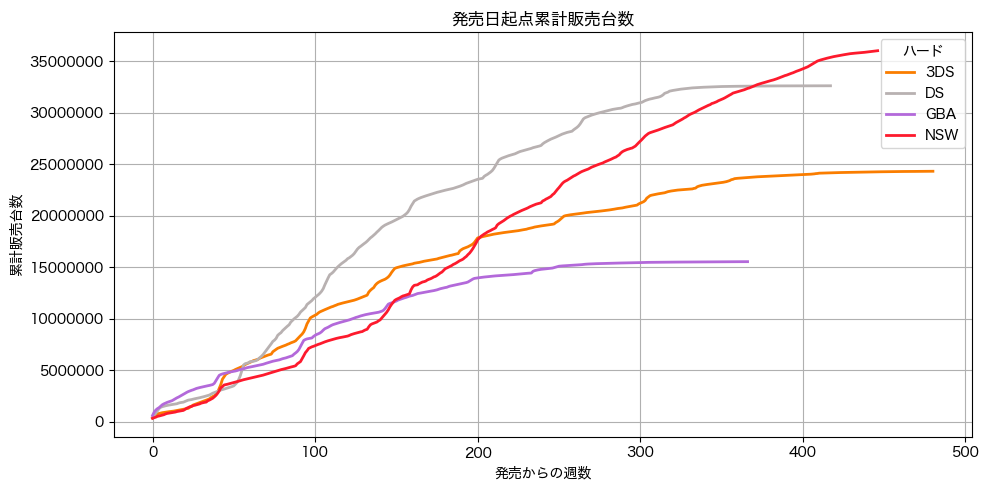

In [7]:

(fig, df) = ph.plot_cumulative_sales_by_delta(hw=["NSW", "GBA", "DS", "3DS"], end=480)

## 2025年月間販売推移

(9月は第3週まで)

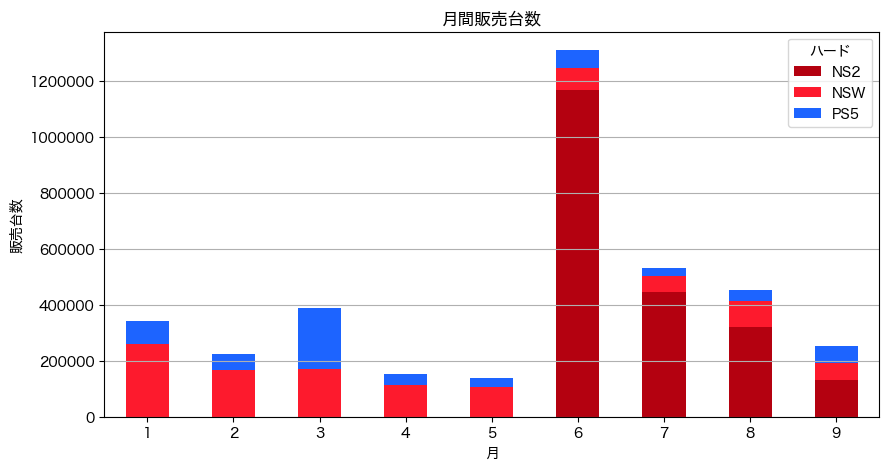

In [8]:
(fig, df) = ph.plot_monthly_bar_by_hard(hw=["NS2", "PS5", "NSW"], year=2025, stacked=True)

In [9]:
df = df.style.format({'NS2': '{:,.0f}', 'NSW': '{:,.0f}', 'PS5': '{:,.0f}'})
display(df)

hw,NS2,NSW,PS5
month,,,
1,0,"260,447","81,587"
2,0,"167,188","56,886"
3,0,"171,921","218,300"
4,0,"113,513","38,983"
5,0,"106,506","32,001"
6,"1,169,684","78,097","63,516"
7,"444,706","57,532","28,959"
8,"319,690","94,517","39,004"
9,"131,392","59,836","61,782"


### Nintendo Switchの月間販売台数： 2023,2024年との比較

9月のSwitchの前年比は大幅に低下しそうです。2024年の9月が強過ぎるんですね。

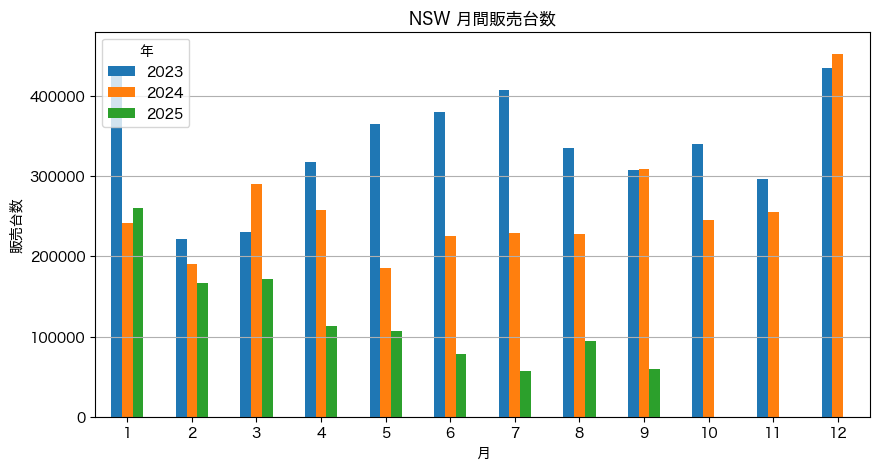

In [10]:
(fig, df) = ph.plot_monthly_bar_by_year(hw="NSW", ymax=480000, begin=datetime(2023,1,1), end=datetime(2025,9,21))

### PlayStation 5の月間販売台数： 2023, 2024年との比較

#### 9月も前年割れの見込み

オータムセールは終わりました。先週は「9月は前年を上回りそう」と書きましたが撤回します。
あと1週間で1万3千台を増やすのは困難です。最終的に9月は前年をわずかに下回るでしょう。

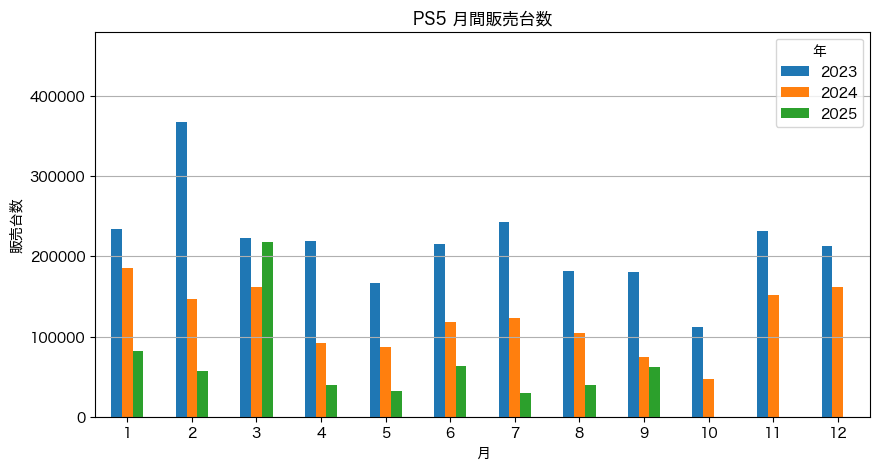

In [11]:
(fig, df) = ph.plot_monthly_bar_by_year(hw="PS5", ymax=480000, begin=datetime(2023,1,1), end=datetime(2025,9,21))

## 累計販売推移

累計については、しばらく状況変化無いでしょう。ホリデーシーズンに各機どこまで上昇カーブが描けるか。

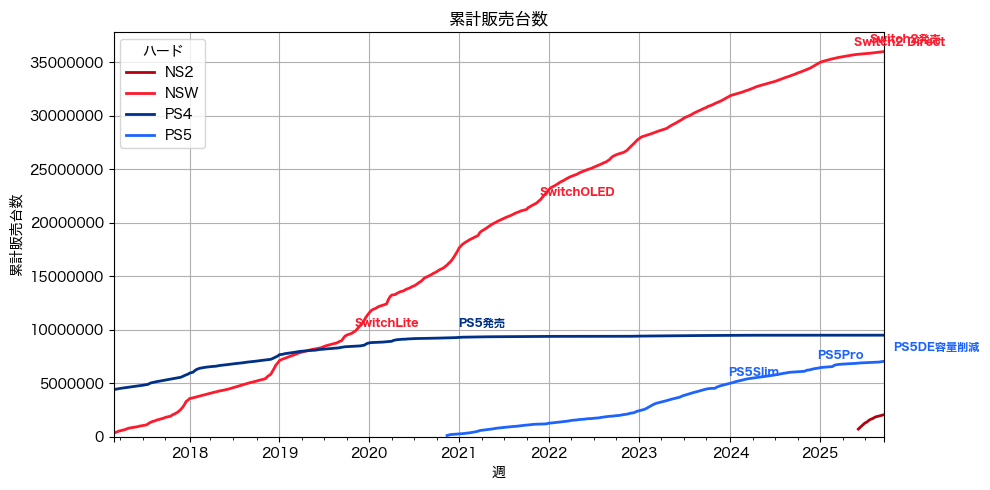

In [12]:
long_range_event_mask = {'hard': 1}
(fig, df) = ph.plot_cumulative_sales(hw=['PS4', 'NS2', 'PS5', 'NSW'], begin=datetime(2017,3,1), event_mask = long_range_event_mask)


## Switch2販売状況

### 歴代機種との比較

#### PS2推移を（一時的に)下回る見込み

Switch2はGBAに次ぐ歴代2位の初動を維持していますが、出荷制限の影響が続いています。
ZAまで出荷増が無いとすると、3週間後のZA直前でPS2の推移を下回りそうです。
(ZAが出たらぶち抜くでしょうが)

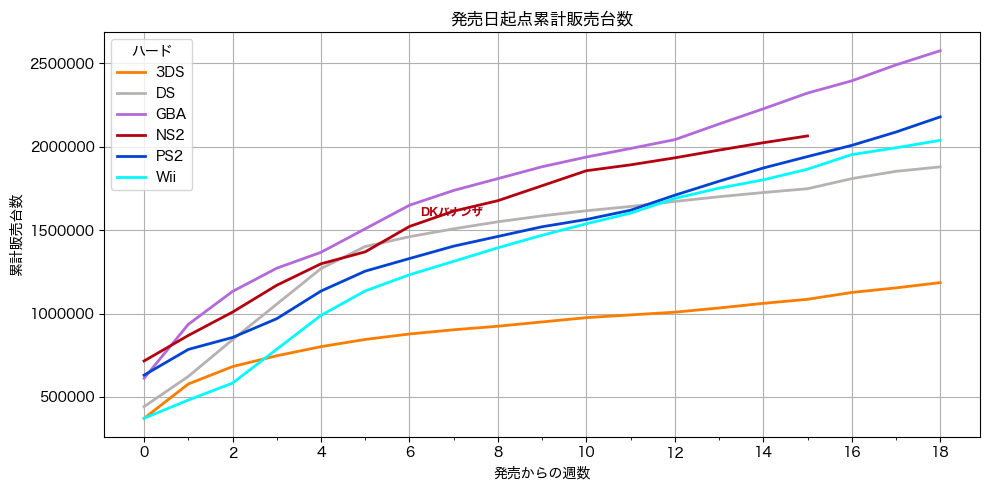

In [13]:
(fig, df) = ph.plot_cumulative_sales_by_delta(hw=["GBA", "NS2", "DS", "PS2", "Wii", "3DS"], 
                                        mode="week", xgrid=2, end=18,
                                        event_mask=report_event_mask)

In [14]:
df12 = df.iloc[df.index == 15]
# df12をunpivotして、列名を"ハード"、"販売数"にする
df12_unpivot = df12.unstack().reset_index()
df12_unpivot.columns = ['ハード', '週数', '販売数']
df12_unpivot.sort_values(by='販売数', ascending=False, inplace=True)
df12_unpivot.set_index('ハード', inplace=True)
display(df12_unpivot.style.format({'販売数': '{:,.0f}'}))

,週数,販売数
ハード,,
GBA,15,"2,322,539"
NS2,15,"2,065,472"
PS2,15,"1,941,656"
Wii,15,"1,865,929"
DS,15,"1,748,799"
3DS,15,"1,085,427"


## Switch/Switch2ロンチ比較

#### 今週のSwitch2はSwitchを下回る

ロンチ週以降のSwitchとSwitch2の販売状況の比較です。
Switchの15週目が一時的に増加してた影響で今週はSwitchを下回りました。
傾向としてはSwitch2は4万台水準を維持し続けています。
ZAは19週目なので、Switcのスプラ2上昇に劣らぬ跳ね上がりを期待したいですね。


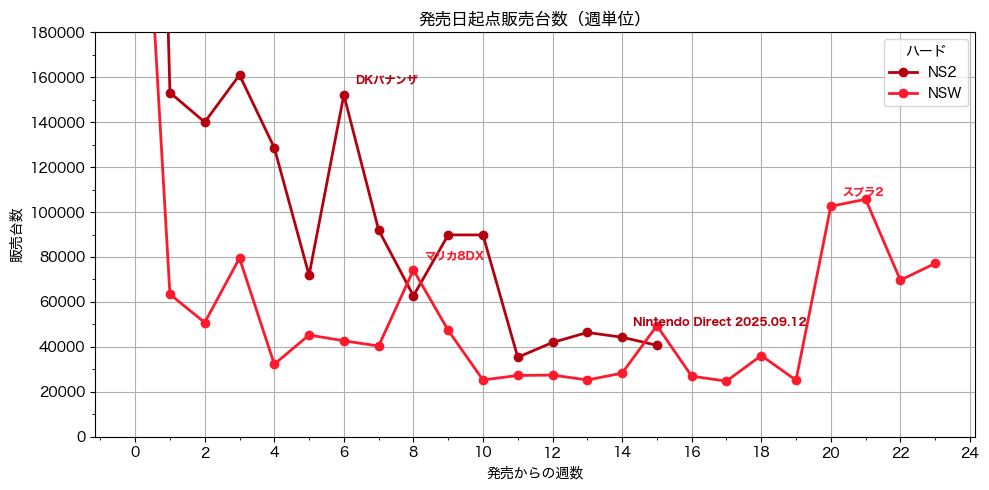

In [19]:
switch_event_mask ={'hard': 5, 'event': 2, 'soft':3, }
(fig, df) = ph.plot_sales_by_delta(hw=["NSW", "NS2"], end=23, ymax=180000, xgrid=2, ygrid=20000, mode="week", event_mask=switch_event_mask)


## 年単位の状況

(2025年については9月までの状況です)

全機種合わせた年毎のハード販売の状況です。
2024年は500万台を割り込む状況でしたが、2025年は500万台を超える可能性があります。
というかSwitch2ローンチ年に超えないとヤバイですね。全てはSwitch2の出荷次第です。
順調なら年間600万の水準も狙えます。

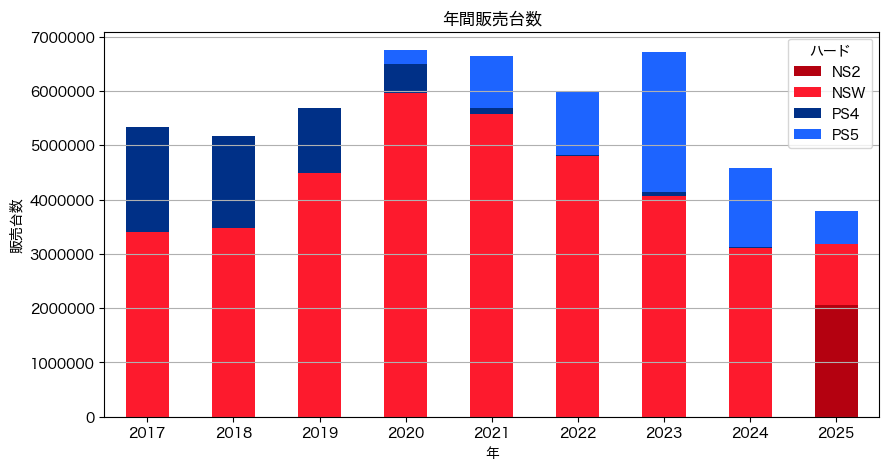

In [17]:
(fig, df) = ph.plot_yearly_bar_by_hard(hw=['PS4', 'PS5', 'NSW', 'NS2'], begin=datetime(2017,1,1), end=datetime(2025,12,31), stacked=True)

Switch2の販売台数の延びにより、任天堂が2025年に記録的シェアを達成する可能性が高まっています。

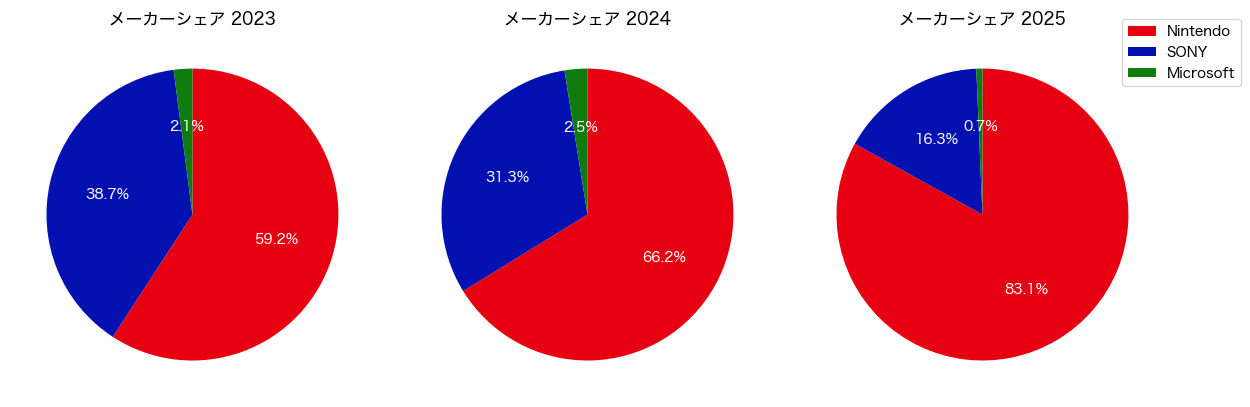

In [18]:
(fig, df) = ph.plot_maker_share_pie(begin_year=2023, end_year=2025)